This work examines customer churn ("attrition") at lending companies. The following dataset found on kaggle.com is available for this purpose: <https://www.kaggle.com/datasets/thedevastator/predicting-credit-card-customer-attrition-with-m>. The dataset contains variables related to the customer's demographics and spending habits with their credit card, which will be explained, analyzed, and used to create Data Science statistical models within this work. In addition to analyzing the data, models are set up within this work that predict or rule out the possible attrition of a customer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import gdown
from google.colab import drive

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, chi2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
output_file = "bank_churners.csv" # name of the file in colab environment
gdown.download('https://drive.google.com/uc?id=15CrXEnGtwnrJnb4TLSDPo3GClcEpyFmv', output_file, quiet=False)

df = pd.read_csv(output_file)
display(df.shape)
df.head()

Downloading...
From: https://drive.google.com/uc?id=15CrXEnGtwnrJnb4TLSDPo3GClcEpyFmv
To: /content/bank_churners.csv
100%|██████████| 1.51M/1.51M [00:00<00:00, 67.6MB/s]


(10127, 23)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


The meanings of the variables are explained in this table:

Variable                          |Typ    |Bedeutung
:---------------                  |:------|:------------------------------------
**CLIENTNUM**                     | int   | Id of the client
**Attrition_Flag**                | chr   | Is the client still existing or attrited?
**Customer_Age**                  | int   | Age of client
**Gender**                        | chr   | Sex of client
**Dependent_count**               | int   | Amount of dependencies (other listed owners of credit card)
**Education_Level**               | chr   | Niveau of education of client
**Marital_Status**                | chr   | The family status of the client
**Income_Category**               | chr   | Category of income the client gets per month
**Card_Category**                 | chr   | Kind of credit card the client obtains
**Months_on_book**                | int   | Amount of months the client is listed as a client
**Total_Relationship_Count**      | int   | Amount of other relations to the lender, can be contracts or similar relations
**Months_Inactive_12_mon**        | int   | Amount of months without usage of credit card in last 12 months
**Contacts_Count_12_mon**         | int   | How often did the client contact the support
**Credit_Limit**.                 | float   | Maximum possible dept
**Total_Revolving_Bal**           | int   | Amount of debt, that will be taken into next accounting period, will be payed back with interest
**Avg_Open_To_Buy**               | float   | Amount of money the client can still use, calculation: *Credit_Limit - Total_Revolving_Bal*
**Total_Amt_Chng_Q4_Q1**          | float   | Relation of spent money in fourth quarter to the amount of money spent in first quarter
**Total_Trans_Amt**               | int   | Total amount of money used in transactions
**Total_Trans_Ct**                | int   | Total amount of transactions with the credit card
**Total_Ct_Chng_Q4_Q1**           | float   | Relation of transactions made in fourth quarter to the amount of transactions made in first quarter
**Avg_Utilization_Ratio**         | float   | To which extend is the credit limit used? Calculation: *Total_Revolving_Balance / Credit_Limit*


Furthermore there are the variables **Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1** and **Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2**. These are Naive Bayes Classifier values calculated by the creator of the dataset using a Naive Bayes Classifier. They do not matter for this work, as custom models are created.

The dataset contains no NaN values.

In [3]:
df.isna().sum()

CLIENTNUM                                                                                                                             0
Attrition_Flag                                                                                                                        0
Customer_Age                                                                                                                          0
Gender                                                                                                                                0
Dependent_count                                                                                                                       0
Education_Level                                                                                                                       0
Marital_Status                                                                                                                        0
Income_Category                                 

# 1.: Explorative Analisis

The pie chart below shows that approximately one in six customers has switched credit institutions.

Text(0.5, 1.0, 'Distribution of existing and attrited customers')

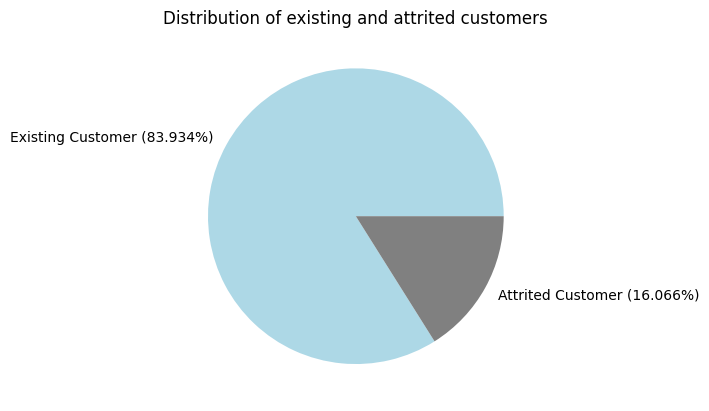

In [4]:
attr_flag_count = df['Attrition_Flag'].value_counts()

plt.pie(
    [attr_flag_count[0]/len(df), attr_flag_count[1]/len(df)],
    labels=[f"Existing Customer ({round(attr_flag_count[0]/len(df)*100, 3)}%)", f"Attrited Customer ({round(attr_flag_count[1]/len(df)*100, 3)}%)"],
    colors=["lightblue", "gray"]
)
plt.title("Distribution of existing and attrited customers")

The bar chart below shows that there are roughly equal numbers of men and women in the data set. Men and women change lenders equally often; no gender changes more often.

Text(0.5, 1.0, 'Distribution of Gender')

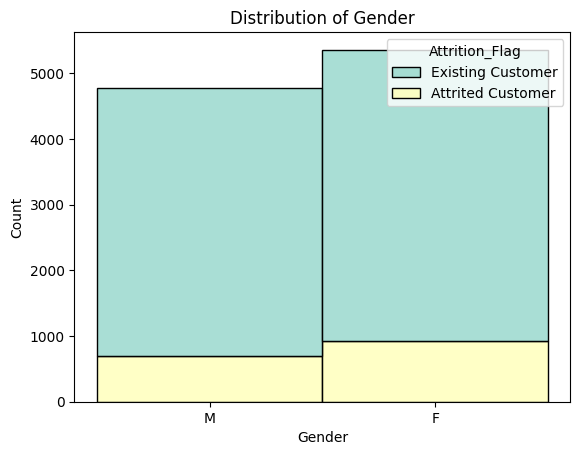

In [5]:
sns.histplot(x=df['Gender'], hue=df['Attrition_Flag'], palette='Set3', multiple='stack')
plt.title("Distribution of Gender")

This histogram shows that the ages of the clients are normally distributed. In general there are a bit more women then men in the dataset. But there are no irregularities in the distribution of mens and womens ages.

Text(0.5, 1.0, 'Age distribtion of men and woman')

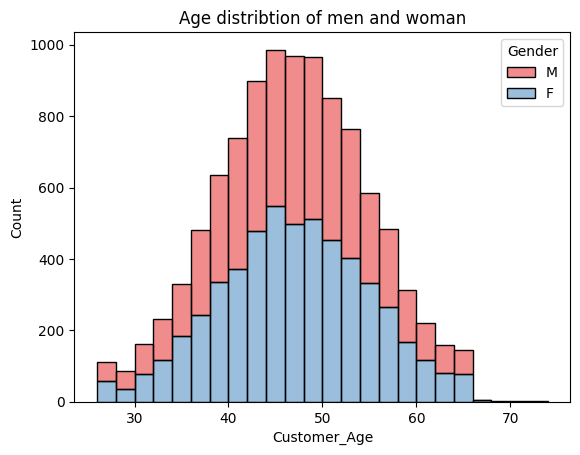

In [6]:
sns.histplot(x=df['Customer_Age'], hue=df['Gender'], palette='Set1', binwidth=2, multiple='stack', alpha=0.5)
plt.title("Age distribtion of men and woman")

The following overview shows the different educational qualifications and the income of the customers. There are many university graduates and high school graduates. A particularly large number of customers earn less than 40,000 US-Dollars (highest proportion among all educational qualifications). It is striking that, according to this figure, there is no high correlation between educational attainment and income. Even doctors often earn "only" 40,000 US-Dollar. Even among the "uneducated", there are many who earn over 120k USD. What is noticeable, however, is that the number of people earning less increases when you compare the numbers from right to left for an educational degree. This curve flattens out the better the educational degree, so there are about the same number of people among PhDs earning 60k, 80k, or 120k USD and above.

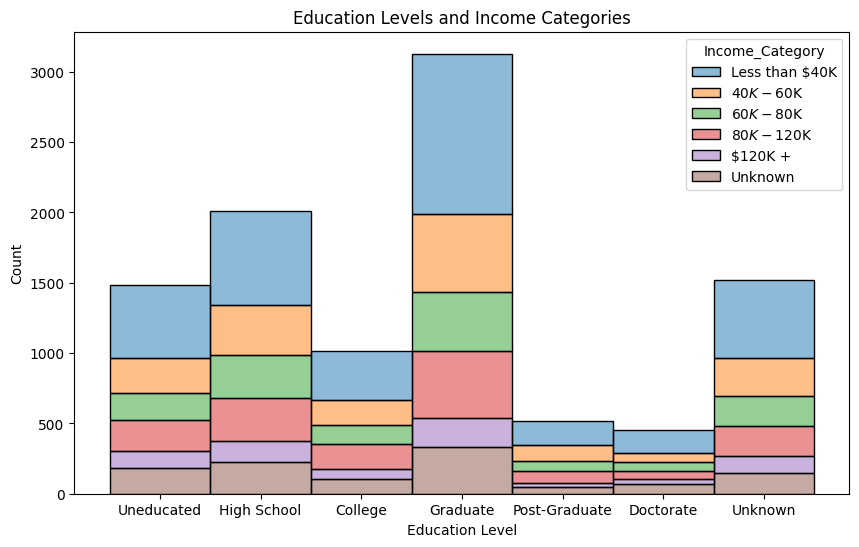

In [7]:
education_order = ["Uneducated", "High School", "College", "Graduate", "Post-Graduate", "Doctorate", "Unknown"]
income_order = ["Less than $40K", "$40K - $60K", "$60K - $80K", "$80K - $120K", "$120K +", "Unknown"]

df['Education_Level'] = pd.Categorical(df['Education_Level'], categories=education_order, ordered=True)
df['Income_Category'] = pd.Categorical(df['Income_Category'], categories=income_order, ordered=True)

plt.figure(figsize=(10, 6))

sns.histplot(data=df, x='Education_Level', hue='Income_Category', alpha=0.5, common_norm=False, multiple='stack')

plt.xlabel('Education Level')
plt.ylabel('Count')
plt.title('Education Levels and Income Categories')
plt.show()

Here it is shown that the length of registration as a customer is normally distributed. Some customers have already been customers for over 50 months, so almost 6 years, while some have only been customers for just over a year. Interestingly, there are many customers who have been customers for 36 months. Perhaps this has to do with a special economic event or a marketing campaign by the lender.

<Axes: xlabel='Months_on_book', ylabel='Count'>

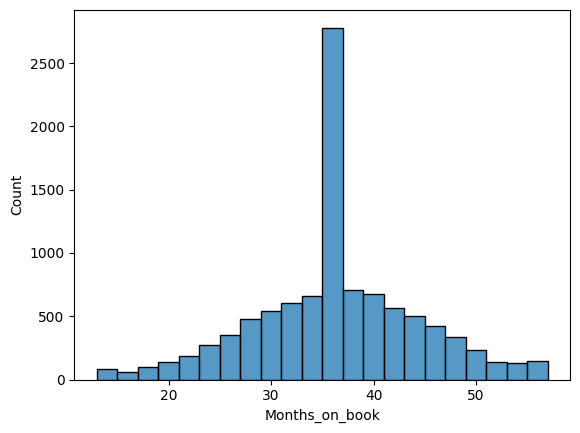

In [8]:
sns.histplot(x=df['Months_on_book'], binwidth=2)

With regard to the types of credit cards that customers use, it can be seen that the blue credit card is the most frequently purchased. Assuming that the value of the color (e.g. gold more valuable than silver) determines the value of the credit card, it can be said that the more expensive the credit card, the fewer users it has.

Text(0.5, 1.0, 'Distribution of Users by Card Category')

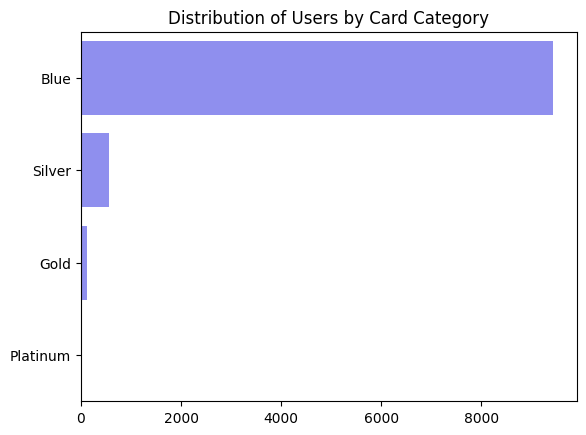

In [9]:
card_cat_count = df['Card_Category'].value_counts()
card_cat_count

sns.barplot(
    x=[card_cat_count[0],
     card_cat_count[1],
     card_cat_count[2],
     card_cat_count[3]],
    y=["Blue", "Silver", "Gold", "Platinum"],
    color="blue",
    alpha=0.5
)
plt.title("Distribution of Users by Card Category")

The credit limit that can be reached by customers is strongly distributed, but not normally distributed. A lionshare of credit limits is located at the borders of the interval (1438.3 - 34516 USD). Many limits are between 1000 and 4000 US dollars, many other limits are around 34000 US dollars.

Min Limit: 1438.3
Max Limit: 34516.0


Text(0.5, 1.0, "Distribution of customer's Credit Limit")

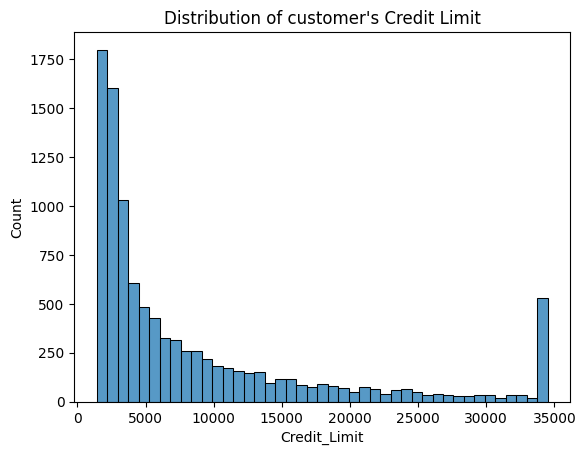

In [10]:
print(f"Min Limit: {min(df['Credit_Limit'])}")
print(f"Max Limit: {max(df['Credit_Limit'])}")
sns.histplot(df['Credit_Limit'])
plt.title("Distribution of customer's Credit Limit")

The following diagram maps the relationship of the variables *Avg_Open_To_Buy* and *Total_Revolving_Bal*. The color of the dot represents the card category. Thus, the monetary values that customers can still spend are plotted against the monetary values with which the customer is indebted. If you look at the highest y-values, you can see that they drop as the x-value gets higher. This is because the x-values are amounts spent that have not yet been repaid. These lower the money values that can be spent. There is often the value x=0, because many customers pay off their debts at the end of the month. The highest possible assumption of debt is 2517 US dollars. This value may have been set by the lender as it represents a visual limit. Calculating the proportion of the next month's takeover in the credit limit, we get *max(Total_Revolving_Bal)/max(Credit_Limit) = 7.3%*

Max Revolving Balance: 2517
Proportion of next months takeover to credit limit: 7.290000000000001


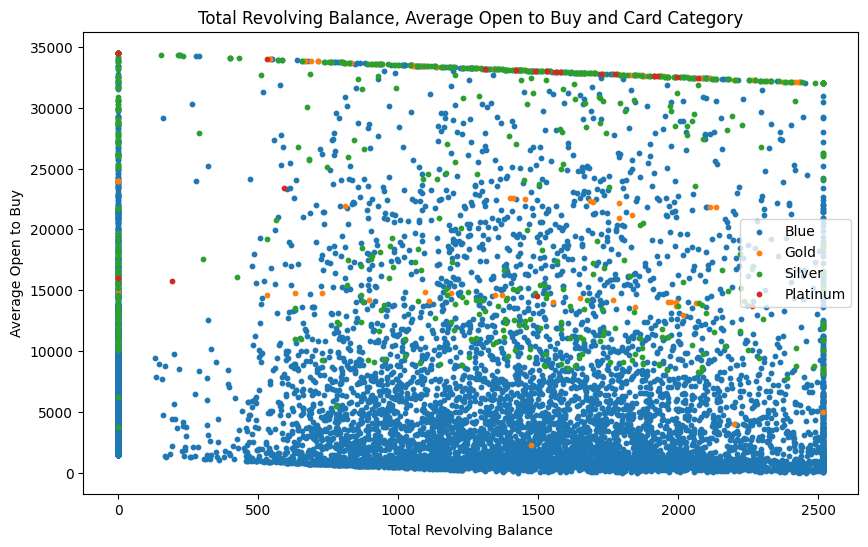

In [11]:
print(f"Max Revolving Balance: {max(df['Total_Revolving_Bal'])}")
print(f"Proportion of next months takeover to credit limit: {round(max(df['Total_Revolving_Bal']/max(df['Credit_Limit'])), 4)*100}")

plt.figure(figsize=(10, 6))
for i, category in enumerate(df['Card_Category'].unique()):
  filtered_df = df[df['Card_Category'] == category]
  plt.scatter(filtered_df['Total_Revolving_Bal'], filtered_df['Avg_Open_To_Buy'], s=10, label=category)

plt.xlabel("Total Revolving Balance")
plt.ylabel("Average Open to Buy")
plt.title("Total Revolving Balance, Average Open to Buy and Card Category")
plt.legend()
plt.show()

This chart shows the share of debt still to be repaid in the credit limit. Interestingly, many customers with low credit limits (up to about 5000 USD) carry over more debt into the next billing period. These are roughly between 750 USD and 2250 USD. This is a large percentage of the credit limit. The further down the right the dot (representing a customer), the higher the proportion of the credit limit that is still to be repaid.

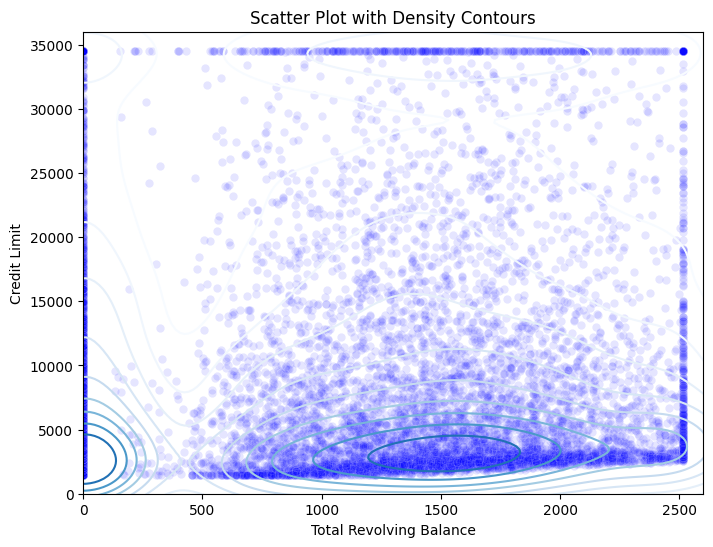

In [12]:
plt.figure(figsize=(8, 6))

sns.scatterplot(
    x="Total_Revolving_Bal",
    y="Credit_Limit",
    data=df,
    color='blue',
    alpha=0.1
)

sns.kdeplot(
    x="Total_Revolving_Bal",
    y="Credit_Limit",
    data=df,
    cmap="Blues"
)

plt.xlim(0, 2600)
plt.ylim(0, 36000)
plt.xlabel('Total Revolving Balance')
plt.ylabel('Credit Limit')
plt.title('Scatter Plot with Density Contours')
plt.show()

Here the relationship status of the customers is visualized. Most customers are married or single, only a few are divorced or do not disclose their status. It also shows that there are just no remarkable differences in income between the relationship statuses. Thus, it could have been that singles are more career-focused and therefore find themselves in higher income brackets, but this is not the case.

Text(0.5, 1.0, 'Marital Status and Income Category')

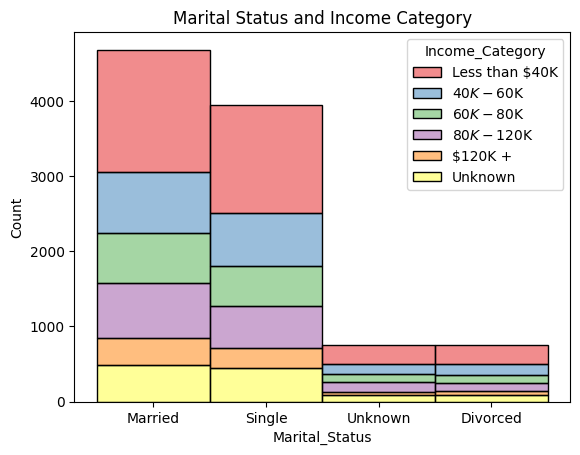

In [13]:
sns.histplot(x=df['Marital_Status'], hue=df['Income_Category'], palette="Set1", multiple='stack', alpha=0.5)
plt.title("Marital Status and Income Category")

This overview shows the number of dependents, i.e. other people who also use the credit card. Many users name 2 or 3 other co-users, slightly fewer use the card with even more people. It is striking that only a few people use their credit card alone. In addition, it would have been interesting to see that people who have married share their credit card more often than singles. But again, there are no significant differences in the distribution of relationship statuses among the numbers of dependents.

Text(0.5, 1.0, "Distribution of customer's dependent count and Marital Status")

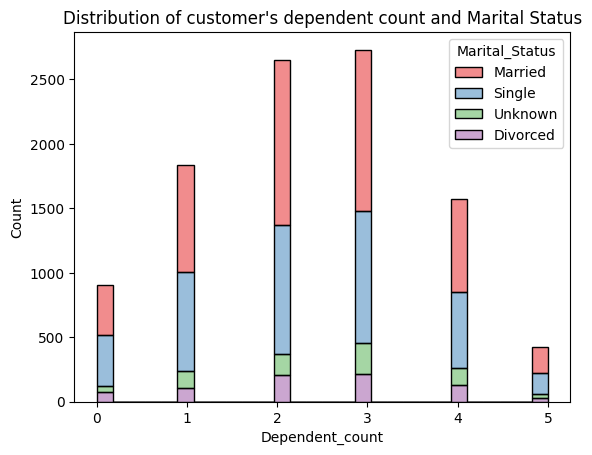

In [14]:
sns.histplot(x=df['Dependent_count'], hue=df['Marital_Status'], palette="Set1", multiple='stack', alpha=0.5)
plt.title("Distribution of customer's dependent count and Marital Status")

This bar chart shows the total number of connections (dependencies) of the customer with the lender, e.g. further contracts or connections. The maximum here is 6 connections. The majority of customers not only have the credit card relationship to which the data record refers, but also other connections. It is noticeable that relatively more customers leave who have fewer relationships with the credit institution than customers who have more relationships with the credit institution. This is probably due to the degree of dependence on the lender.

Text(0.5, 1.0, 'Amount of relationships with the lender')

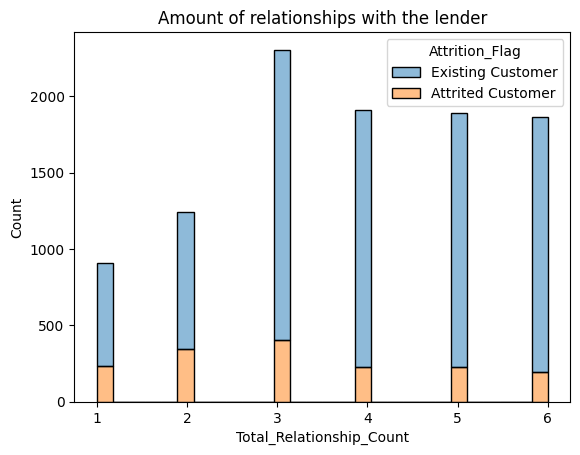

In [15]:
sns.histplot(x=df['Total_Relationship_Count'], hue=df['Attrition_Flag'], multiple='stack', alpha=0.5)
plt.title("Amount of relationships with the lender")

This overview shows how many months within the last 12 months no transaction was made by a customer. Many people have months in which they do not use the credit card at all. Most often the credit card was not used for 3 months.

Text(0.5, 1.0, 'Inactive months in the last 12 months')

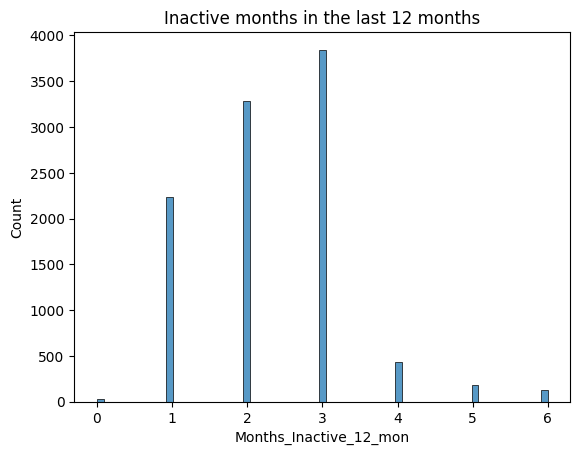

In [16]:
sns.histplot(x=df['Months_Inactive_12_mon'])
plt.title("Inactive months in the last 12 months")

The following shows how often customers contacted support for credit cards. This is in relation to the termination of the customer relationship. The more often a customer contacts support, the more likely it is that the customer will later terminate their customer relationship. If the support was never contacted, the customers are still customers, after 5-6 times of contact the customer is very likely to leave.

Text(0.5, 1.0, 'Attrition by amounts of contacting Support')

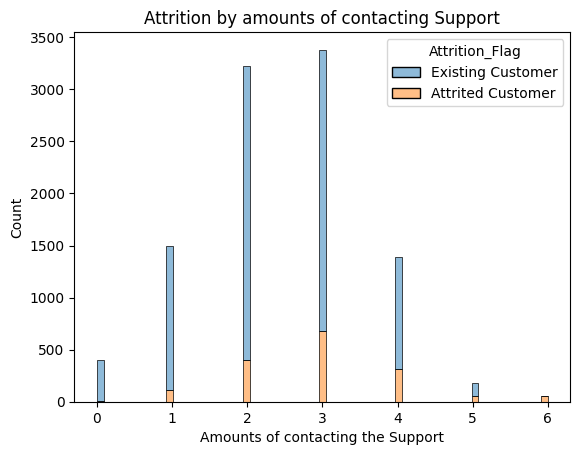

In [17]:
sns.histplot(x=df['Contacts_Count_12_mon'], hue=df['Attrition_Flag'], multiple='stack', alpha=0.5)
plt.xlabel("Amounts of contacting the Support")
plt.title("Attrition by amounts of contacting Support")

This display shows how many transactions have been made by individual customers and how much money they have already used in total. In addition, for each customer in the chart it is indicated via color whether he is still a customer (blue) or no longer a customer (orange). The more transactions have been made and the higher the amount of money used, the closer it is that the customer is still a customer. Customers who have dropped out have generally made fewer transactions and used less money.

However, what is also noticeable is that there are 3-4 money value ranges in which customers spend their money. Once between 0-2500, between 2500-5000, between 7500-10000 and around 15000 US dollars. Comparison was made with gender, relationship status and credit card type as these variables have between 2 and 4 categorical values (see above). No relationship was found between these money spending groups and the variables.

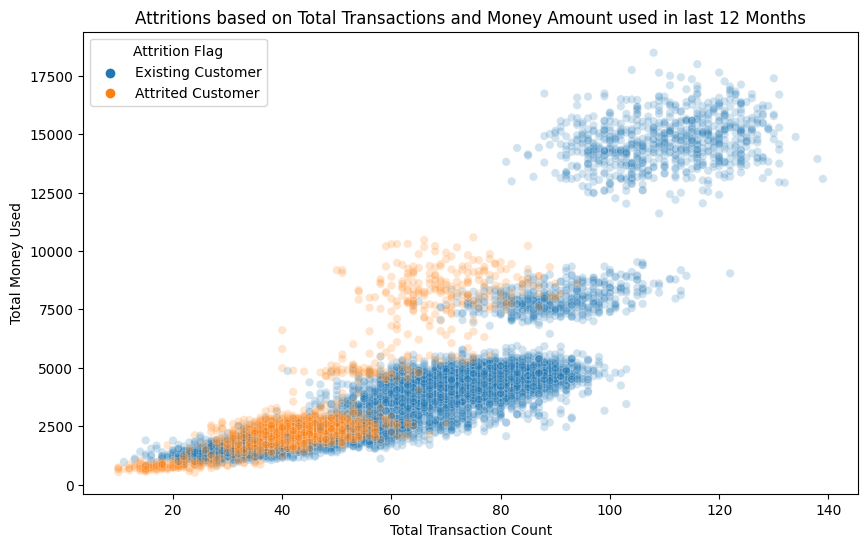

In [18]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x='Total_Trans_Ct',
    y='Total_Trans_Amt',
    hue='Attrition_Flag',
    data=df,
    alpha=0.2,
)

plt.xlabel('Total Transaction Count')
plt.ylabel('Total Money Used')
plt.title('Attritions based on Total Transactions and Money Amount used in last 12 Months')
plt.ticklabel_format(style='plain', axis='y')
plt.legend(title='Attrition Flag')
plt.show()

Visualizations for Total Transaction Amount and Gender, Marital Status and Card Category. Other comparisons would make no sense because the variables are numeric or categorical but too much categories.

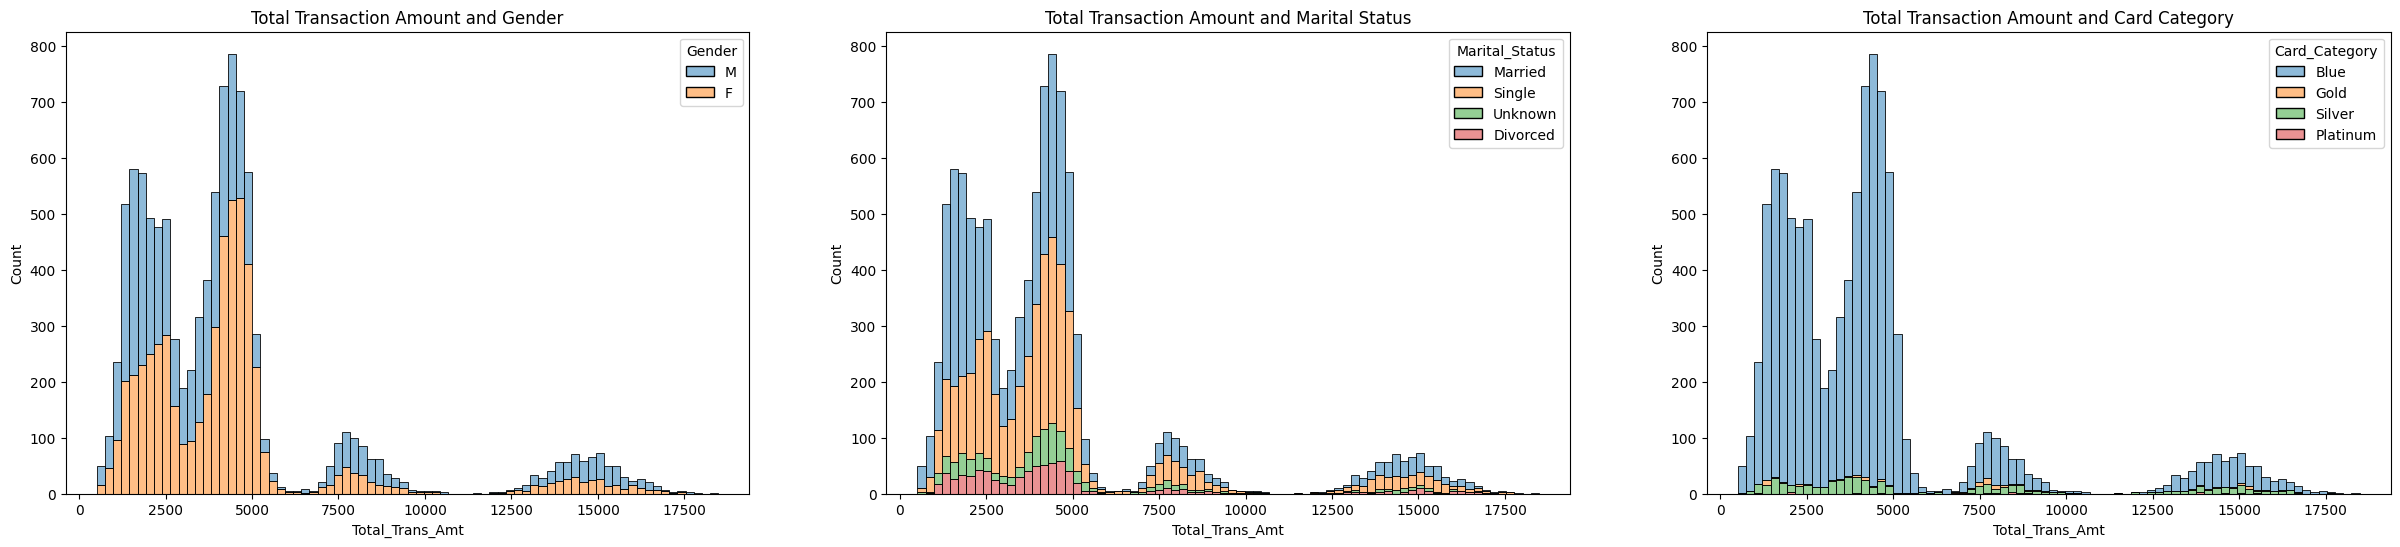

In [19]:
plt.figure(figsize=(30,6))

plt.subplot(131)
sns.histplot(x=df['Total_Trans_Amt'], hue=df['Gender'], multiple='stack', alpha=0.5)
plt.title("Total Transaction Amount and Gender")

plt.subplot(132)
sns.histplot(x=df['Total_Trans_Amt'], hue=df['Marital_Status'], multiple='stack', alpha=0.5)
plt.title("Total Transaction Amount and Marital Status")

plt.subplot(133)
sns.histplot(x=df['Total_Trans_Amt'], hue=df['Card_Category'], multiple='stack', alpha=0.5)
plt.title("Total Transaction Amount and Card Category")

plt.show()

However, the number of transactions are more evenly distributed, there are no perceptible groupings.

Text(0.5, 1.0, 'Distribution of Total Transactions')

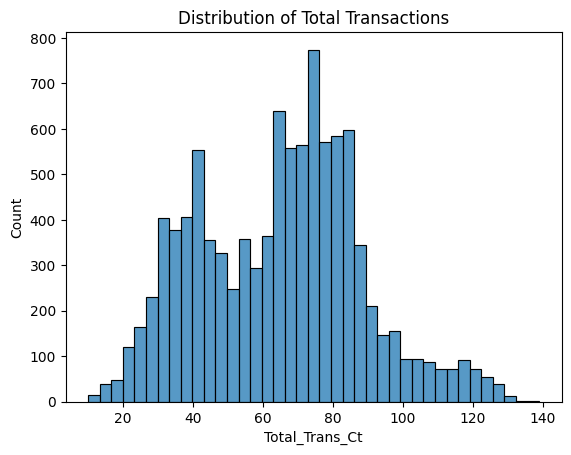

In [20]:
sns.histplot(x=df['Total_Trans_Ct'])
plt.title("Distribution of Total Transactions")

This figure shows how the spending and transaction behavior of customers changed in the 4th quarter compared to the 1st quarter. The values are given as percentages, so if a customer has, for example, the value 1.2 for *Total_Amt_Chng_Q4_Q1*, then the customer has spent 120% of what he spent the quarter before, i.e. 20% more. The same principle applies to *Total_Ct_Chng_Q4_Q1*. It is noticeable that less money is spent in Q1 than in Q4. In contrast to the previous quarter, on average 76% is still spent and 71% of transactions are executed.

This can possibly be attributed to the fact that costly events take place in the last months of the year, especially in Western countries. In December, Christmas and New Year's Eve take place, for which shopping is done. Black Week takes place in November, during which a lot of shopping is done. Some people go on a winter vacation.

Average change of amount that was spent: 75.99000000000001%
Average change of transactions made: 71.22%


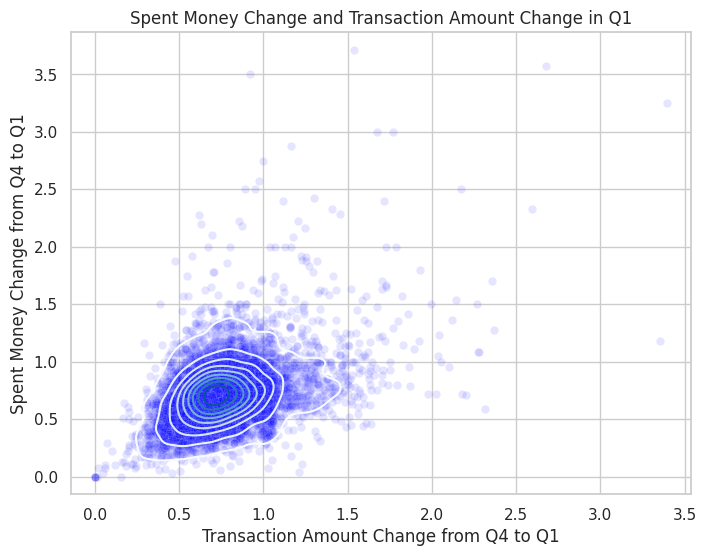

In [21]:
print(f"Average change of amount that was spent: {round(np.mean(df['Total_Amt_Chng_Q4_Q1']), 4)*100}%")
print(f"Average change of transactions made: {round(np.mean(df['Total_Ct_Chng_Q4_Q1']), 4)*100}%")

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.scatterplot(
    x="Total_Amt_Chng_Q4_Q1",
    y="Total_Ct_Chng_Q4_Q1",
    data=df,
    color='blue',
    alpha=0.1
)

sns.kdeplot(
    x="Total_Amt_Chng_Q4_Q1",
    y="Total_Ct_Chng_Q4_Q1",
    data=df,
    cmap="Blues"
)

plt.xlabel('Transaction Amount Change from Q4 to Q1')
plt.ylabel('Spent Money Change from Q4 to Q1')
plt.title('Spent Money Change and Transaction Amount Change in Q1')
plt.show()

It was to be expected that this effect of spending a lot of money would be greater for families (married people) than for singles, but the proportional spending and the number of transactions are equally normally distributed in each case. In some cases, married customers spend even more money in the 4th quarter (blue color at x>1 quite dominant).

Text(0.5, 1.0, 'Change of transactions from Q4 to Q1, coloring by Marital Status')

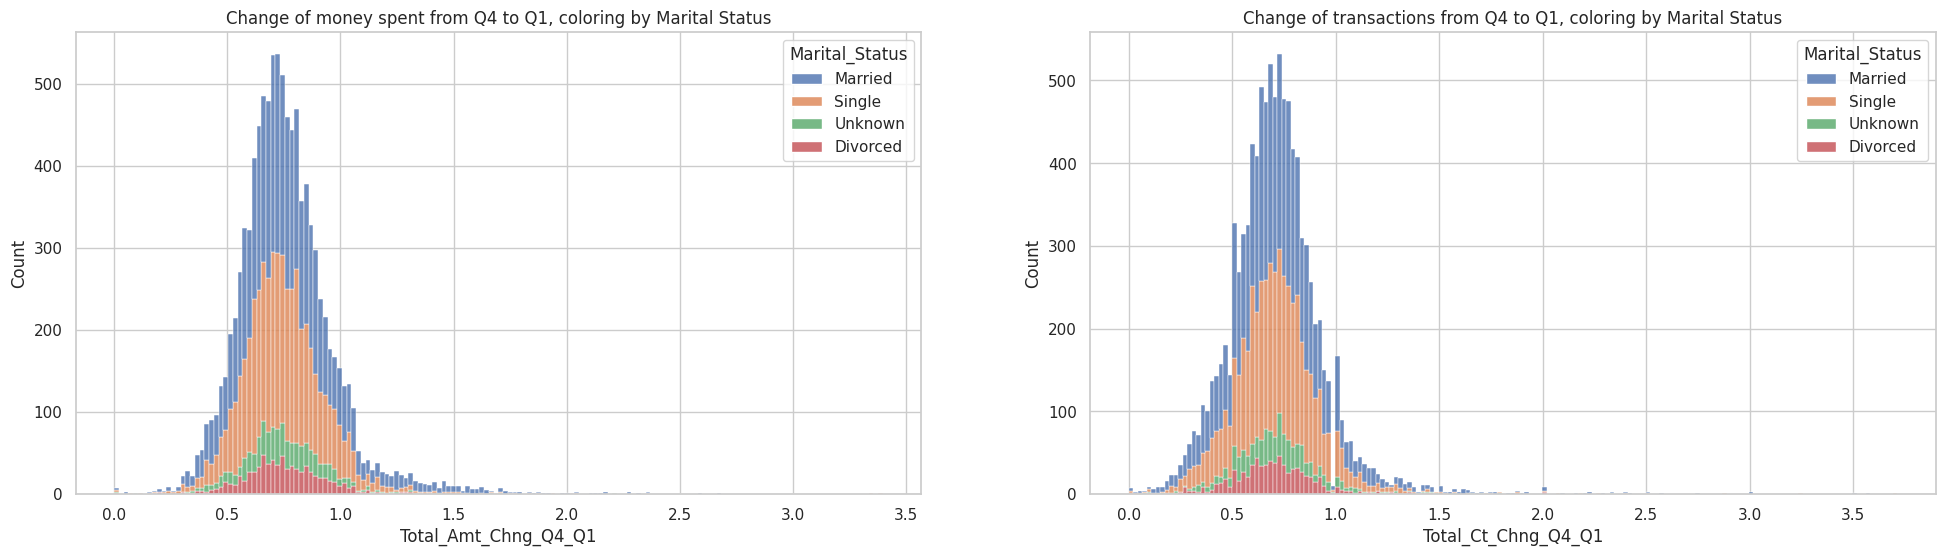

In [22]:
plt.figure(figsize=(24, 6))

plt.subplot(121)
sns.histplot(x=df['Total_Amt_Chng_Q4_Q1'], hue=df['Marital_Status'], multiple='stack', alpha=0.8)
plt.title("Change of money spent from Q4 to Q1, coloring by Marital Status")

plt.subplot(122)
sns.histplot(x=df['Total_Ct_Chng_Q4_Q1'], hue=df['Marital_Status'], multiple='stack', alpha=0.8)
plt.title("Change of transactions from Q4 to Q1, coloring by Marital Status")

# 2.: Prepare Dataset

Firstly, the Naive Bayes and the client id values are erased and the dataset is split into X and y values.

In [23]:
df = df[df.columns[1:-2]]

X = df.drop(columns=['Attrition_Flag'])
y = df['Attrition_Flag']

New structure of dataset:

In [24]:
X.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


y can be two values: Customer is existing or attrited.

In [25]:
y[:30]

0     Existing Customer
1     Existing Customer
2     Existing Customer
3     Existing Customer
4     Existing Customer
5     Existing Customer
6     Existing Customer
7     Existing Customer
8     Existing Customer
9     Existing Customer
10    Existing Customer
11    Existing Customer
12    Existing Customer
13    Existing Customer
14    Existing Customer
15    Existing Customer
16    Existing Customer
17    Existing Customer
18    Existing Customer
19    Existing Customer
20    Existing Customer
21    Attrited Customer
22    Existing Customer
23    Existing Customer
24    Existing Customer
25    Existing Customer
26    Existing Customer
27    Existing Customer
28    Existing Customer
29    Existing Customer
Name: Attrition_Flag, dtype: object

The y-values must be numerically encoded to be able to work with them later.

1 = Existing Customer, 0 = Attrited Customer

In [26]:
le = LabelEncoder()
y_enc = le.fit_transform(y)
y_enc[:30]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1])

In [27]:
X_ohe = pd.get_dummies(X)

In [28]:
X_ohe

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,...,Income_Category_Less than $40K,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_$120K +,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,...,0,0,1,0,0,0,1,0,0,0
1,49,5,44,6,1,2,8256.0,864,7392.0,1.541,...,1,0,0,0,0,0,1,0,0,0
2,51,3,36,4,1,0,3418.0,0,3418.0,2.594,...,0,0,0,1,0,0,1,0,0,0
3,40,4,34,3,4,1,3313.0,2517,796.0,1.405,...,1,0,0,0,0,0,1,0,0,0
4,40,3,21,5,1,0,4716.0,0,4716.0,2.175,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,50,2,40,3,2,3,4003.0,1851,2152.0,0.703,...,0,1,0,0,0,0,1,0,0,0
10123,41,2,25,4,2,3,4277.0,2186,2091.0,0.804,...,0,1,0,0,0,0,1,0,0,0
10124,44,1,36,5,3,4,5409.0,0,5409.0,0.819,...,1,0,0,0,0,0,1,0,0,0
10125,30,2,36,4,3,3,5281.0,0,5281.0,0.535,...,0,1,0,0,0,0,1,0,0,0


When the columns will be scaled, the column names will not be saved, so they are saved to *scaled_columns_names* now. *columns_to_scale* contains every row that is not ohed.

In [29]:
scaled_columns_names = X_ohe.columns[:14]
columns_to_scale = X_ohe[scaled_columns_names]

Scaling is performed. After scaling the columns receive their old names. The not scaled values of the dataset with the ohed values are dropped out.

In [30]:
standard_scaler = StandardScaler()
scaled_columns = standard_scaler.fit_transform(columns_to_scale)

X_scaled_columns = pd.DataFrame(scaled_columns)
X_scaled_columns.columns = scaled_columns_names

X_ohe_columns = X_ohe.drop(scaled_columns_names, axis=1)

Now, the ohed and the scaled dataset must be concatenated to form one complete dataset again.

In [31]:
df_concat = pd.concat([X_scaled_columns, X_ohe_columns], axis=1)
df_concat.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,...,Income_Category_Less than $40K,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_$120K +,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,-0.165406,0.503368,0.384621,0.763943,-1.327136,0.492404,0.446622,-0.473422,0.488971,2.623494,...,0,0,1,0,0,0,1,0,0,0
1,0.333570,2.043199,1.010715,1.407306,-1.327136,-0.411616,-0.041367,-0.366667,-0.008486,3.563293,...,1,0,0,0,0,0,1,0,0,0
2,0.583058,0.503368,0.008965,0.120579,-1.327136,-2.219655,-0.573698,-1.426858,-0.445658,8.367214,...,0,0,0,1,0,0,1,0,0,0
3,-0.789126,1.273283,-0.241473,-0.522785,1.641478,-1.315636,-0.585251,1.661686,-0.734100,2.942843,...,1,0,0,0,0,0,1,0,0,0
4,-0.789126,0.503368,-1.869317,0.763943,-1.327136,-2.219655,-0.430877,-1.426858,-0.302868,6.455682,...,0,0,1,0,0,0,1,0,0,0


# 3.: Logistic Regression Feature Selector

Here, the logistic regression is trained and evaluated.
However, several logistic regressions are trained in the following. They differ in the number of variables (features) that are used. The goal is to find out with how many variables the model works best. Thus, in the first model the most influential variable is used, in the second model the two most influential variables are used, and so on. Again training and test sets are created, with which the models are trained and tested.

In the following still the parameters of the LogisticRegression are explained:

*penalty='l2'* ensures that Ridge Regression mode is used, means that features can never be assigned the value 0, if one would set the penalty to *l1*, this would be possible, because Lasso Regression mode is used.

*solver='liblinear'* represents the coefficient optimization mode. It also depends on the penalty. Since the dataset is not really large, *liblinear* is the appropriate choice.

*multi_class='auto'* lets the algorithm automatically detect whether it is binary or multinomial classification.

*verbose=0* ensures no outputs during creation and during training.

In [32]:
lrsel_scores_training, lrsel_scores_test = [], [] # lists for saving acc scores

X_train, X_test, y_train, y_test = train_test_split(df_concat, y, test_size=0.1, shuffle=True, random_state=44)

model = LogisticRegression(penalty='l2', solver='liblinear', multi_class='auto', verbose=0);
model.fit(X_train, y_train);
print("Accuracy of Model without Feature Selection:")
print("Train: ", model.score(X_train, y_train), ", test: ", model.score(X_test, y_test)) # acc values for main model
logreg_coefficients = model.coef_[0]
sorted_indices = np.argsort(np.abs(logreg_coefficients))[::-1] # sorting coefficients by height

for n_features in range(25):
  n_features+=1 # for loop starts at 0, without +1 no features in first LogReg
  print(f"-------------------------------------")
  print(f"{n_features} features:")

  top_indices = sorted_indices[:n_features]

  print(f"Indices selected: {top_indices}")
  lr_selected = df_concat[df_concat.columns[top_indices]] # select columns of complete df

  X_train, X_test, y_train, y_test = train_test_split(lr_selected, y, test_size=0.1, random_state=44, shuffle=True)

  model2 = LogisticRegression(penalty='l2', solver='liblinear', multi_class='auto')
  model2.fit(X_train, y_train)

  current_model_scores = [model2.score(X_train, y_train), model2.score(X_test, y_test)]; # testing model
  lrsel_scores_training.append(current_model_scores[0])
  lrsel_scores_test.append(current_model_scores[1])
  print(f"Accuracy scores, train: {current_model_scores[0]}, test: {current_model_scores[1]}")

Accuracy of Model without Feature Selection:
Train:  0.9049813473776608 , test:  0.9091806515301086
-------------------------------------
1 features:
Indices selected: [11]
Accuracy scores, train: 0.8332236120254554, test: 0.8351431391905232
-------------------------------------
2 features:
Indices selected: [11 10]
Accuracy scores, train: 0.8233486943164362, test: 0.8223099703849951
-------------------------------------
3 features:
Indices selected: [11 10 15]
Accuracy scores, train: 0.8277375466315559, test: 0.8173741362290227
-------------------------------------
4 features:
Indices selected: [11 10 15 33]
Accuracy scores, train: 0.8274083827079218, test: 0.8193484698914116
-------------------------------------
5 features:
Indices selected: [11 10 15 33  7]
Accuracy scores, train: 0.8721746763221417, test: 0.8736426456071076
-------------------------------------
6 features:
Indices selected: [11 10 15 33  7  3]
Accuracy scores, train: 0.8821593153390388, test: 0.8835143139190523
---

With the indices sorted by size, one can now sort the names of the columns. One can see here that according to the sklearn LogReg algorithm both the total number of transactions and the total amount of money used most strongly determine the classification as an existing customer or attrited customer.

In [33]:
sorted_variable_names = df_concat.columns[sorted_indices]

for id, element in enumerate(sorted_variable_names):
  print(f"{id+1}.: {element}")

1.: Total_Trans_Ct
2.: Total_Trans_Amt
3.: Gender_M
4.: Card_Category_Blue
5.: Total_Revolving_Bal
6.: Total_Relationship_Count
7.: Total_Ct_Chng_Q4_Q1
8.: Marital_Status_Married
9.: Contacts_Count_12_mon
10.: Card_Category_Silver
11.: Months_Inactive_12_mon
12.: Income_Category_$40K - $60K
13.: Income_Category_Unknown
14.: Income_Category_Less than $40K
15.: Income_Category_$120K +
16.: Education_Level_Graduate
17.: Education_Level_College
18.: Education_Level_High School
19.: Income_Category_$60K - $80K
20.: Card_Category_Gold
21.: Education_Level_Uneducated
22.: Dependent_count
23.: Education_Level_Unknown
24.: Marital_Status_Divorced
25.: Marital_Status_Unknown
26.: Card_Category_Platinum
27.: Credit_Limit
28.: Education_Level_Doctorate
29.: Total_Amt_Chng_Q4_Q1
30.: Gender_F
31.: Customer_Age
32.: Marital_Status_Single
33.: Income_Category_$80K - $120K
34.: Avg_Open_To_Buy
35.: Avg_Utilization_Ratio
36.: Education_Level_Post-Graduate
37.: Months_on_book


The results can be plotted. It shows up that the insertion of few features leads to a relatively small Accuracy, which is nevertheless respectable (approx. 82%). Only from 8 variables the Accuracies level off at approx. 90%. It is not necessarily so that more variables imply a higher Accuracy. Interestingly, the model is somewhat underfitted. With more features considered, the test set accuracies are higher than those of the training set.

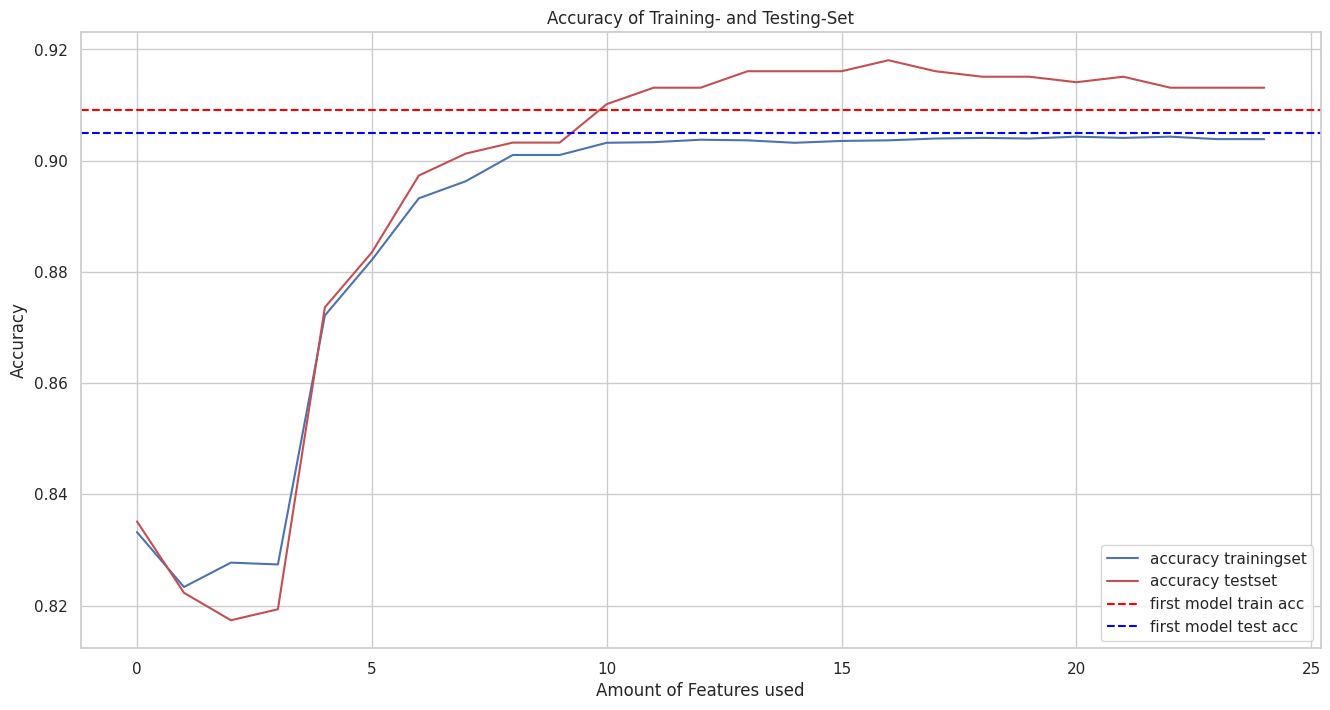

In [34]:
plt.figure(figsize=(16, 8))
plt.plot(lrsel_scores_training, label="accuracy trainingset", color="b")
plt.plot(lrsel_scores_test, label="accuracy testset", color="r")
plt.axhline(y=0.90918, color='red', linestyle='--', label='first model train acc')
plt.axhline(y=0.90498, color='blue', linestyle='--', label='first model test acc')
plt.xlabel("Amount of Features used")
plt.ylabel("Accuracy")
plt.title("Accuracy of Training- and Testing-Set")
plt.legend()
plt.show()

# 4.: KBest Analysis

In the following, the Chi2 algorithm is used to select the best variables to predict the churning behaviour of the clients. The selected columns are processed with Logistic Regression again.

In [35]:
kbest_scores_training = []
kbest_scores_test = []

previous_cols = []
new_selected_cols = []

for n_features in range(30):
  selector = SelectKBest(score_func=chi2, k=n_features+1) # initiate and fit the kbest selector with ch2 function and amount of features
  X_new = selector.fit_transform(X_ohe, y_enc)

  selected_cols_np = selector.get_support(indices=True) # save column indices
  selected_cols = []
  for i, element in enumerate(selected_cols_np): # np array needs to be converted to python list for next operations
    selected_cols.append(element)

  new_selected_cols.append(set(selected_cols) - set(previous_cols)) # subtract new indices from previous indeces, only new index remains
  previous_cols.clear()

  for i, element in enumerate(selected_cols):
    previous_cols.append(element)

  print(f"#{n_features+1}, selected features indices: ", selector.get_support(indices=True))

  standard_scaler = StandardScaler()
  X_new_scaled = standard_scaler.fit_transform(X_new) # scale df with selected cols

  X_train, X_test, y_train, y_test = train_test_split(X_new_scaled, y_enc, test_size=0.15, random_state=44, shuffle=True)

  model = LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto') # perform Log Reg
  model.fit(X_train, y_train)

  current_scores = [model.score(X_train, y_train), model.score(X_test, y_test)] # calculate scores
  kbest_scores_training.append(current_scores[0])
  kbest_scores_test.append(current_scores[1])
  print(f"#{n_features+1}, scores: Train: {current_scores[0]}, Test: {current_scores[1]}")
  print(f"-------------------------------------")
print(f"-------------------------------------")
print(f"Training mean acc: {np.mean(kbest_scores_training)}")
print(f"Test mean acc: {np.mean(kbest_scores_test)}")

#1, selected features indices:  [10]
#1, scores: Train: 0.841756709654932, Test: 0.8256578947368421
-------------------------------------
#2, selected features indices:  [ 7 10]
#2, scores: Train: 0.841756709654932, Test: 0.8256578947368421
-------------------------------------
#3, selected features indices:  [ 6  7 10]
#3, scores: Train: 0.841756709654932, Test: 0.8256578947368421
-------------------------------------
#4, selected features indices:  [ 6  7 10 11]
#4, scores: Train: 0.86813059137911, Test: 0.8631578947368421
-------------------------------------
#5, selected features indices:  [ 5  6  7 10 11]
#5, scores: Train: 0.8762635064482398, Test: 0.8703947368421052
-------------------------------------
#6, selected features indices:  [ 3  5  6  7 10 11]
#6, scores: Train: 0.8870686650400836, Test: 0.8828947368421053
-------------------------------------
#7, selected features indices:  [ 3  4  5  6  7 10 11]
#7, scores: Train: 0.8891599860578598, Test: 0.8894736842105263
-------

Every newly chosen variable was added to *new_selected_cols*. Like that an oder of best to worst variables for predicting churning was created which is printed here. It is a bit different from the previous one but the total transaction amount and count still occupy some of the top positions.

In [36]:
ordered_col_indices = [list(d)[0] for d in new_selected_cols]
sorted_variable_names = X_ohe.columns[ordered_col_indices]
for i, element in enumerate(sorted_variable_names):
  print(f"{i+1}.: {element}")

1.: Total_Trans_Amt
2.: Total_Revolving_Bal
3.: Credit_Limit
4.: Total_Trans_Ct
5.: Contacts_Count_12_mon
6.: Total_Relationship_Count
7.: Months_Inactive_12_mon
8.: Avg_Utilization_Ratio
9.: Total_Ct_Chng_Q4_Q1
10.: Total_Amt_Chng_Q4_Q1
11.: Avg_Open_To_Buy
12.: Education_Level_Doctorate
13.: Gender_M
14.: Income_Category_$60K - $80K
15.: Gender_F
16.: Customer_Age
17.: Months_on_book
18.: Income_Category_Less than $40K
19.: Marital_Status_Married
20.: Dependent_count
21.: Marital_Status_Single
22.: Education_Level_Post-Graduate
23.: Card_Category_Platinum
24.: Income_Category_$40K - $60K
25.: Education_Level_High School
26.: Income_Category_$120K +
27.: Marital_Status_Unknown
28.: Education_Level_Unknown
29.: Card_Category_Silver
30.: Education_Level_Graduate


The accuracies can be plotted again. The accuracy for training and test is around 90%. This time there is no overfitting.

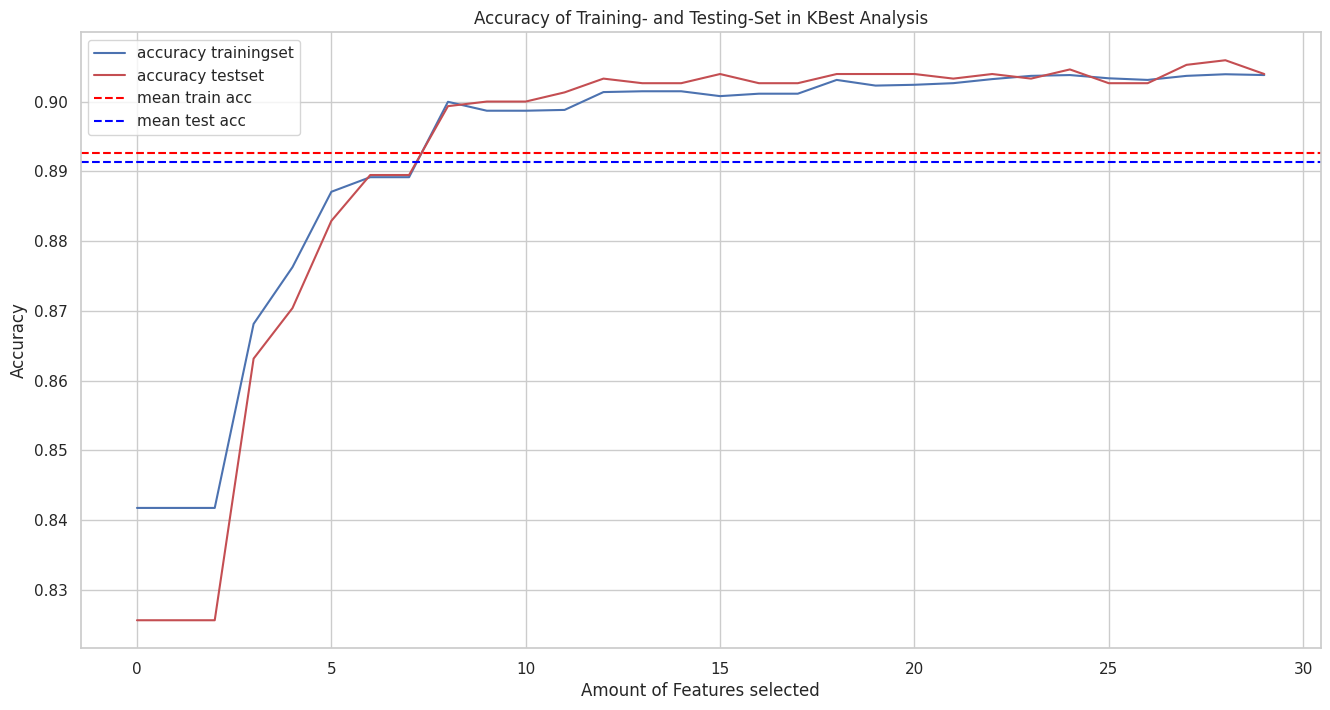

In [37]:
plt.figure(figsize=(16, 8))
plt.plot(kbest_scores_training, label="accuracy trainingset", color="b")
plt.plot(kbest_scores_test, label="accuracy testset", color="r")
plt.axhline(y=0.89258, color='red', linestyle='--', label='mean train acc')
plt.axhline(y=0.89127, color='blue', linestyle='--', label='mean test acc')
plt.xlabel("Amount of Features selected")
plt.ylabel("Accuracy")
plt.title("Accuracy of Training- and Testing-Set in KBest Analysis")
plt.legend()
plt.show()

# 5.: Gaussian Naive Bayes with Cross Validation

Since the creator of the Churner dataset trained a Gaussian Naive Bayes, a Gaussian Naive Bayes (GNB) is also trained in this work. In addition, cross validation will also be applied in this model.

This piece of code delivers the training of a GNB with cross validation. The training of the GNB is written as a function because multiple versions of the datasets x-values should be fed in.

In [38]:
def gnb_model(folds, x):
  X_train, X_test, y_train, y_test = train_test_split(x, y_enc, random_state=44, test_size=0.30, shuffle=True)

  gaussian_nb = GaussianNB()

  scores = cross_val_score(gaussian_nb, X=X_train, y=y_train, cv=folds, scoring='accuracy')

  for fold, score in enumerate(scores):
    print(f'Fold #{fold+1} : {score}')

  avg_acc = np.mean(scores)
  print(f'Average score: {avg_acc}')

  return avg_acc

This model is trained with the ohed values. Other values are not scaled or changed in another way.

In [39]:
gnb_acc_ohe = gnb_model(20, X_ohe)

Fold #1 : 0.8845070422535212
Fold #2 : 0.9126760563380282
Fold #3 : 0.8929577464788733
Fold #4 : 0.8873239436619719
Fold #5 : 0.8929577464788733
Fold #6 : 0.9098591549295775
Fold #7 : 0.9070422535211268
Fold #8 : 0.8929577464788733
Fold #9 : 0.9011299435028248
Fold #10 : 0.884180790960452
Fold #11 : 0.8785310734463276
Fold #12 : 0.8898305084745762
Fold #13 : 0.8954802259887006
Fold #14 : 0.9180790960451978
Fold #15 : 0.8954802259887006
Fold #16 : 0.8898305084745762
Fold #17 : 0.9180790960451978
Fold #18 : 0.8728813559322034
Fold #19 : 0.9067796610169492
Fold #20 : 0.8785310734463276
Average score: 0.8954547624731439


Here the concatenated dataframe which has already been used in Logistic Regression, is used to train the GNB.

In [40]:
gnb_acc_concat = gnb_model(20, df_concat)

Fold #1 : 0.8788732394366198
Fold #2 : 0.8845070422535212
Fold #3 : 0.8732394366197183
Fold #4 : 0.8816901408450705
Fold #5 : 0.8788732394366198
Fold #6 : 0.8929577464788733
Fold #7 : 0.8929577464788733
Fold #8 : 0.8873239436619719
Fold #9 : 0.8870056497175142
Fold #10 : 0.867231638418079
Fold #11 : 0.8502824858757062
Fold #12 : 0.8785310734463276
Fold #13 : 0.8785310734463276
Fold #14 : 0.9067796610169492
Fold #15 : 0.8700564971751412
Fold #16 : 0.8785310734463276
Fold #17 : 0.8870056497175142
Fold #18 : 0.847457627118644
Fold #19 : 0.8813559322033898
Fold #20 : 0.8728813559322034
Average score: 0.8788036126362696


Here, the ohed dataset was scaled completely before it was fed into the GNB.

In [41]:
gnb_acc_scaled = gnb_model(20, standard_scaler.fit_transform(X_ohe))

Fold #1 : 0.8788732394366198
Fold #2 : 0.8845070422535212
Fold #3 : 0.8732394366197183
Fold #4 : 0.8816901408450705
Fold #5 : 0.8788732394366198
Fold #6 : 0.8929577464788733
Fold #7 : 0.8929577464788733
Fold #8 : 0.8873239436619719
Fold #9 : 0.8870056497175142
Fold #10 : 0.867231638418079
Fold #11 : 0.8502824858757062
Fold #12 : 0.8785310734463276
Fold #13 : 0.8785310734463276
Fold #14 : 0.9067796610169492
Fold #15 : 0.8700564971751412
Fold #16 : 0.8785310734463276
Fold #17 : 0.8870056497175142
Fold #18 : 0.847457627118644
Fold #19 : 0.8813559322033898
Fold #20 : 0.8728813559322034
Average score: 0.8788036126362696


The GNB that has no scaled values (only ohed values) performs best with almost 90% accuracy. Interestingly the concatenated dataset and the completely scaled dataset have an equal accuracy score (almost 88%).

# 7.: Train a complex Neural Network

In this step, a complex neural network is created that consists of different layers. The basis for this is the Pytorch library.

The neural network consists of the following layers:

1. Linear: "Normal" layer, trains Linear Equation, has Weights (are multiplied by Input) and Biases (are added to Input) that are trained. Has fixed input size and output size.

2. Sigmoid: activation function, returns values between 0 and 1, good for binary classification, because output in binary classification also between 0 and 1.

3. ReLU (Rectangular Linear Unit): Activation Function, returns values between 0 and positive infinity, good for feature selection since non-positive values are nullified, but still leaves the data somewhat spread out (does not compact as much).

4. BatchNorm1d: one-dimensional batch normalization, provides value normalization within the neural network, good to perform controlled gradient optimization, especially when data is fed in batches, adjusts value ranges of the input, training can be sped up by BatchNorm Layers.

5. Dropout: layer that randomly drops out connections between nodes of two layers with probability p. Brings more randomness to the neural network, thus prevents overfitting.

The network itself always consists of a similar combination of layers. First comes a linear layer, then the Activation Function, then BatchNorm, then Dropout (except at the beginning and end, too much dropout randomness "destroyed" input at the beginning and made training difficult). This approach is a common practice to create neural networks: You let the values move through the "main" layer, then the activation function is applied, and then the values are normalized. Here, the dropout layer is also used to create randomness, as arbitrary connections between the BatchNorm layer and the next linear layer are removed. The size of the layers decreases as one progresses in the neural network to condense information. Eventually, a prediction is obtained.

In [42]:
class ComplexModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ComplexModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.sigmoid1 = nn.Sigmoid()
        self.bn1 = nn.BatchNorm1d(hidden_size)

        self.layer2 = nn.Linear(hidden_size, 160)
        self.sigmoid2 = nn.Sigmoid()
        self.bn2 = nn.BatchNorm1d(160)
        self.drop1 = nn.Dropout(p=0.75)

        self.layer3 = nn.Linear(160, 120)
        self.relu1 = nn.ReLU()
        self.bn3 = nn.BatchNorm1d(120)
        self.drop2 = nn.Dropout(p=0.75)

        self.layer4 = nn.Linear(120, 80)
        self.sigmoid3 = nn.Sigmoid()
        self.bn4 = nn.BatchNorm1d(80)
        self.drop3 = nn.Dropout(p=0.75)

        self.layer5 = nn.Linear(80, 40)
        self.sigmoid4 = nn.Sigmoid()
        self.bn5 = nn.BatchNorm1d(40)
        self.drop4 = nn.Dropout(p=0.75)

        self.layer6 = nn.Linear(40, output_size)
        self.output_sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.sigmoid1(x)
        x = self.bn1(x)

        x = self.layer2(x)
        x = self.sigmoid2(x)
        x = self.bn2(x)
        x = self.drop1(x)

        x = self.layer3(x)
        x = self.relu1(x)
        x = self.bn3(x)
        x = self.drop2(x)

        x = self.layer4(x)
        x = self.sigmoid3(x)
        x = self.bn4(x)
        x = self.drop3(x)

        x = self.layer5(x)
        x = self.sigmoid4(x)
        x = self.bn5(x)
        x = self.drop4(x)

        x = self.layer6(x)
        x = self.output_sigmoid(x)
        return x

The following code provides the model training and testing.
When running the function, you can define the following:

1. *model*: Which neural network (model) should be trained?

2. *train_loader*: DataLoader used for training, provides random training data in batches so that the whole train dataset is not fed per epoch.

3. *test_loader*: DataLoader used for testing, provides random training data in batches so that not the whole test dataset is fed per epoch.

4. *num_epochs*: Number of epochs in which data is fed to the network for training and testing.

5. *learning_rate*: Learning rate, speed/extreme at which the neural network parameters are adjusted.

6. *mode*: "start" if *model* has not been trained yet, "continue" if *model* is a model which has already been trained.

The loss function used is Binanary Cross Entropy (BCE), also known as Logarithmic Loss. The logarithmic function is used to calculate the loss. Therefore, strong deviations in predictions are also strongly penalized, which is good for training the network. It is used by default for binary classification and is also used here because the values between 0 and 1 on the logarithmic function yield values between negative infinity and 0.

Stochastic Gradient Descend (SGD) is used as optimization function.

In [43]:
def train_model(model, train_loader, test_loader, num_epochs=400, learning_rate=1, mode="start"):
    losses_training, accuracy_traindata, accuracy_testdata = [], [], []
    criterion = nn.BCELoss()

    model.train() # train mode, activates BatchNorm

    for epoch in range(num_epochs):
        #lr = 2 if epoch < 20 else learning_rate #(0.75 if epoch > 650 else learning_rate) # other possible learning rate
        lr = learning_rate if mode == "continue" else (3 if epoch < 20 else learning_rate) # change of learning rate

        optimizer = optim.SGD(model.parameters(), lr=lr)

        for inputs, labels in train_loader:
            optimizer.zero_grad()

            outputs = model(inputs)  # forward pass, calculate the Neural Net

            loss = criterion(outputs.view(-1), labels.view(-1))
            losses_training.append(loss.item())

            loss.backward() # Backprop

            optimizer.step() # update neural net params

        if ((epoch+1) % 5 == 0): print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        model.eval() # test mode, deaktivieren BatchNorm

        train_acc = test_model(data_loader=train_loader, model=model) # calculate accs
        test_acc = test_model(data_loader=test_loader, model=model)
        if ((epoch+1) % 5 == 0): print(f"Accs: Train: {train_acc}, test: {test_acc}")

        accuracy_traindata.append(train_acc)
        accuracy_testdata.append(test_acc)
        model.train()  # train mode for next epoch

    return losses_training, accuracy_traindata, accuracy_testdata

def test_model(data_loader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for inputs, labels in data_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()  # if pred higher than 0.5, then absolute pred is 1, otherwise 0
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (correct / total)

In this chunk, models and the data to train the neural network are prepared.
First, the dataset (ohe values combined with scaled values) is randomly divided into x and y for training and testing.
For reproducibility a *random_state* is set. A seed is also used for Pytorch functions.
The X and y values are stored as pd.DataFrame, but must be formatted as Pytorch tensor to be processed below. The X and y tensors are combined into a tensor dataset, which is used to create a data loader. Finally, the neural network is created.

In [44]:
torch.manual_seed(44)
batch_size = 512
X_train, X_test, y_train, y_test = train_test_split(df_concat, pd.DataFrame(y_enc), test_size=0.2, random_state=44, shuffle=True)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32) # convert to tensor
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor) # create tensor dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # DataLoader with shuffle=True, for avoiding patterns in data (neutrality)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # here DataLoader with shuffle = False, should present real world data in with usual patterns

model = ComplexModel(input_size=37, hidden_size=128, output_size=1) # neural net

Train neural network with train and test loader, 800 epochs.

In [45]:
train_losses, train_acc, test_acc = train_model(model, train_loader, test_loader, num_epochs=800)

Epoch [5/800], Loss: 0.3267
Accs: Train: 0.9059375385754845, test: 0.9126357354392892
Epoch [10/800], Loss: 0.2739
Accs: Train: 0.8765584495741267, test: 0.8820335636722606
Epoch [15/800], Loss: 0.2693
Accs: Train: 0.9096407850882607, test: 0.9160908193484699
Epoch [20/800], Loss: 0.2903
Accs: Train: 0.8940871497346007, test: 0.9017769002961501
Epoch [25/800], Loss: 0.2077
Accs: Train: 0.9154425379582768, test: 0.920533070088845
Epoch [30/800], Loss: 0.2237
Accs: Train: 0.9155659795087027, test: 0.9200394866732478
Epoch [35/800], Loss: 0.2415
Accs: Train: 0.9174176027650908, test: 0.9210266535044422
Epoch [40/800], Loss: 0.1833
Accs: Train: 0.9206270830761635, test: 0.9244817374136229
Epoch [45/800], Loss: 0.1643
Accs: Train: 0.9234662387359586, test: 0.9279368213228035
Epoch [50/800], Loss: 0.2222
Accs: Train: 0.9251944204419208, test: 0.9284304047384008
Epoch [55/800], Loss: 0.1884
Accs: Train: 0.926922602147883, test: 0.9299111549851925
Epoch [60/800], Loss: 0.2250
Accs: Train: 0.93

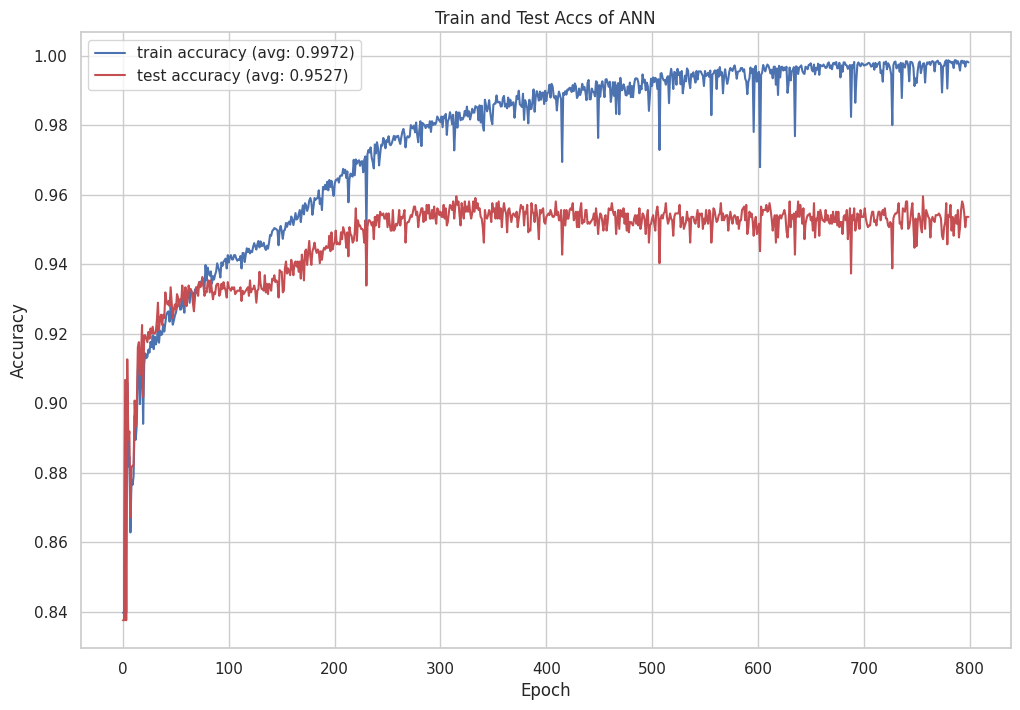

In [46]:
nn_train_avg = np.round(np.mean(train_acc[750:]), 4)
nn_test_avg = np.round(np.mean(test_acc[750:]), 4)

plt.figure(figsize=(12,8))
plt.plot(train_acc, label=f"train accuracy (avg: {nn_train_avg})", c="b")
plt.plot(test_acc, label=f"test accuracy (avg: {nn_test_avg})", c="r")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Test Accs of ANN")
plt.legend()
plt.show()

Training can be continued if wanted...

In [47]:
train_losses, train_acc, test_acc = train_model(model, train_loader, test_loader, num_epochs=20, mode="continue")

Epoch [5/20], Loss: 0.0090
Accs: Train: 0.9982718182940378, test: 0.9526159921026653
Epoch [10/20], Loss: 0.0273
Accs: Train: 0.9983952598444636, test: 0.9536031589338598
Epoch [15/20], Loss: 0.0242
Accs: Train: 0.9983952598444636, test: 0.9545903257650543
Epoch [20/20], Loss: 0.0500
Accs: Train: 0.9981483767436119, test: 0.9536031589338598


# 7.: Conclusion

Here the accuracies of the created models are plotted against each other. Its visible that the neural network has the highest accuracy, although it is overfitted much. The other models have more or less similar models.

Text(0.5, 1.0, 'Test Accuracies for created Models')

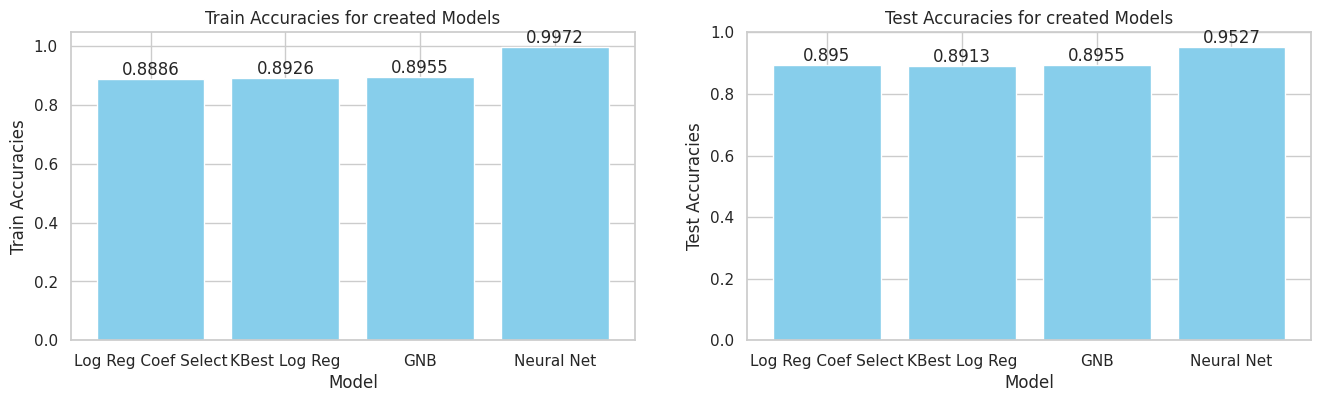

In [48]:
train_accs = [np.mean(lrsel_scores_training), np.mean(kbest_scores_training), gnb_acc_ohe, nn_train_avg]
test_accs = [np.mean(lrsel_scores_test), np.mean(kbest_scores_test), gnb_acc_ohe, nn_test_avg]

bar_names = ["Log Reg Coef Select", "KBest Log Reg", "GNB", "Neural Net"]

plt.figure(figsize=(16,4))

plt.subplot(121)
bars = plt.bar(bar_names, train_accs, color='skyblue')
for bar, value in zip(bars, train_accs):
  value = round(value, 4)
  plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(value), ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('Train Accuracies')
plt.title('Train Accuracies for created Models')


plt.subplot(122)
bars = plt.bar(bar_names, test_accs, color='skyblue')
for bar, value in zip(bars, test_accs):
  value = round(value, 4)
  plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(value), ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('Test Accuracies')
plt.title('Test Accuracies for created Models')

In context of variables that determine the attrition of a customer, it can be said, that the activity of the client is important. The more transactions a client does and the higher the amount the client spends in total, the more likely is a remaining of that customer.